In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
data = pd.read_csv('data/rating_complete.csv')
print(len(data))
data.head(2)

57633278


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [3]:
anime = pd.read_csv('data/anime.csv')
anime = anime.rename(columns={"MAL_ID": "anime_id"})
anime.head(2)

,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [4]:
data_train = data
my_animelist = pd.read_csv('400000.csv')

In [5]:
genres = []

for i in range(len(anime)):
    genres.extend(anime.iloc[i]['Genres'].split(', '))

colms = list(set(genres))

df_genres = pd.DataFrame(columns=colms)
df_genres['anime_id'] = anime['anime_id']
df_genres = df_genres.fillna(0)
df_genres.index = df_genres['anime_id']
df_genres.drop('anime_id', axis=1, inplace=True)

for i in anime['anime_id'].values:
    list_genres = anime.loc[anime['anime_id'] == i]['Genres'].values[0].split(', ')
    for j in list_genres:
        df_genres.at[i, j] = 1

sum_col = [sum(df_genres[i]) for i in df_genres.columns]

for i in df_genres.columns:
    if sum(df_genres[i]) < np.percentile(np.array(sum_col), 10):
        try:
            df_genres.drop(i, axis=1, inplace=True)
        except KeyError:
            pass

df_genres.head(3)

,Thriller,Psychological,Shounen,Seinen,Comedy,Samurai,Cars,Mystery,Mecha,Dementia,...,Space,Adventure,Supernatural,Shounen Ai,Parody,Military,Drama,Game,Sci-Fi,Sports
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
5,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,1,0
6,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


limit by years

In [6]:
max_year = 9999
min_year = 2000

anime_id = []
year = []

for i in anime['anime_id']:
    anime_id.append(i)
    try:
        year.append(int(re.findall('[0-9]{4}', str(anime.loc[anime['anime_id'] == i]['Aired'].values[0]))[0]))
    except IndexError:
        year.append(8888)

df_year = pd.DataFrame({'anime_id': anime_id, 'year': year})
df_year = df_year.loc[(df_year['year'] < max_year)&(df_year['year'] > min_year)]

data_train = data_train.loc[data_train['anime_id'].isin(df_year['anime_id'])]
my_animelist = my_animelist.loc[my_animelist['anime_id'].isin(df_year['anime_id'])]
len(data_train)

52982646

In [7]:
my_type = anime.loc[anime['Type'] == 'TV']['anime_id'].values.tolist()
data_train = data_train.loc[data_train['anime_id'].isin(my_type)]
len(data_train)

36654228

### reducing amount of data

In [8]:
popularity_anime = data_train.groupby('anime_id')['rating'].count().reset_index().sort_values('rating', ascending=False)
popularity_anime['rating_rank'] = popularity_anime['rating'].rank()
popularity_anime.drop('rating', axis=1, inplace=True)
popularity_anime.head(3)

,anime_id,rating_rank
442,1535,3547.0
1584,16498,3546.0
1377,11757,3545.0


In [9]:
data_train = pd.merge(data_train, popularity_anime, how='left', on='anime_id')

In [10]:
user_sum_rating = data_train.groupby('user_id')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_sum_rating.head(3)

,user_id,rating_rank
0,189037,6144310.5
1,68042,6080171.0
2,283786,5996304.0


In [11]:
user_count_rating = data_train.groupby('user_id')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_count_rating.head(3)

,user_id,rating_rank
0,189037,3371
1,68042,3234
2,162615,3070


In [12]:
user_rating = pd.merge(user_sum_rating, user_count_rating, how='left', on='user_id')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,1822.696678
1,68042,1880.077613
2,283786,2071.262176


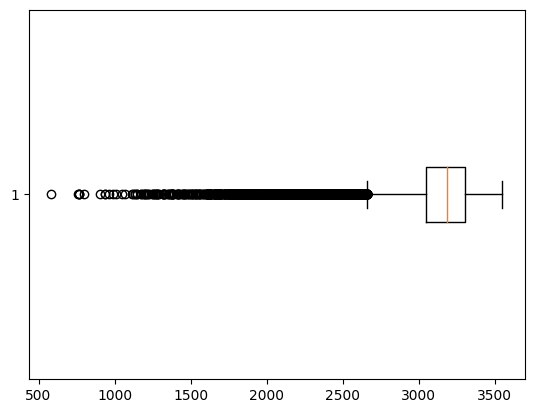

In [13]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

selected interquartile range 

Q1=2886.75, Q3=3078.958591822144


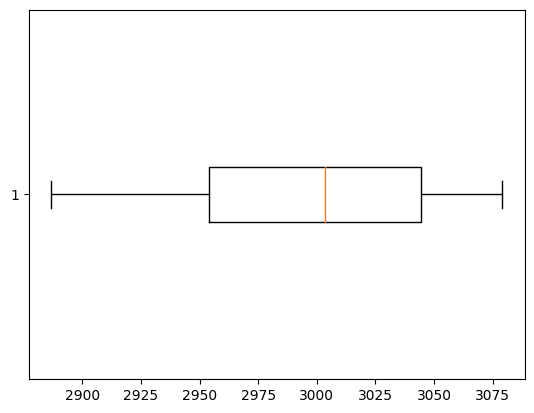

In [14]:
Q1 = user_rating['rating_rank'].quantile(0.1)
Q3 = user_rating['rating_rank'].quantile(0.3)
print(f'Q1={Q1}, Q3={Q3}')
user_rating_iqr = user_rating.loc[(user_rating['rating_rank'] < Q3) & (user_rating['rating_rank'] > Q1)]
user_list = user_rating_iqr['user_id'].tolist()
plt.boxplot(user_rating_iqr['rating_rank'], vert=False)
plt.show()

In [15]:
data_train = data_train.loc[data_train['user_id'].isin(user_list)]
# data_train.drop('rating_rank', axis=1, inplace=True)
data_train = pd.concat([data_train, my_animelist], ignore_index=True)
len(data_train)

10862558

In [16]:
import implicit
from scipy.sparse import csr_matrix

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=100,
                                        regularization=0.05, 
                                        alpha=2.0,
                                        iterations=20,
                                        random_state=38)

# train the model on a sparse matrix of user/item/confidence weights
user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='anime_id',
                                  values='rating',
                                  fill_value=0)

# scipy resets indexes
idALS_anime_id = dict((i, j) for i, j in enumerate(user_item_matrix.columns))

user_item_matrix = user_item_matrix.astype(float)
user_item_matrix_csr = csr_matrix(user_item_matrix).tocsr()

model.fit(user_item_matrix_csr)

C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Python311\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.64s/it]


In [17]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
#user_item_matrix_csr = bm25_weight(user_item_matrix_csr, K1=100, B=0.8)

In [18]:
id_score = model.recommend(-1, user_item_matrix_csr[-1], N=250, filter_already_liked_items=True)
anime_id = [idALS_anime_id[i] for i in id_score[0]]
ALScore = dict((i, j) for i, j in zip(anime_id, id_score[1]))

In [19]:
my_animelist = my_animelist.loc[my_animelist['rating'] > 6]
my_genres = df_genres[df_genres.index.isin(my_animelist['anime_id'])].mean().values

def rec_final(rec):
    name = []
    date = []
    url = []
    als_score = []
    score_mal = []
    corr = []

    for i in rec:
        if i not in set(my_animelist['anime_id']):
            name.append(anime.loc[anime['anime_id'] == i]['Name'].values[0])
            date.append(anime.loc[anime['anime_id'] == i]['Aired'].values[0])
            url.append('https://myanimelist.net/anime/' + str(i))
            if type(rec) == list:
                als_score.append(ALScore[i])
            score_mal.append(anime.loc[anime['anime_id'] == i]['Score'].values[0])
            corr.append(0)
            if df_genres.loc[int(i)].sum() != 0:
                corr[-1] = (np.corrcoef(my_genres, df_genres.loc[int(i)])[0, 1])

    df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'score mal': score_mal, 'correlation': corr})
    df['rank'] = df['score mal'].rank() + df['correlation'].rank()
    df = df.sort_values('rank', ascending=False)
    if type(rec) == list:
        df =  pd.DataFrame({'name': name, 'date': date, 'url': url, 'ALS score': als_score, 'score mal': score_mal, 'correlation': corr})
        df['rank'] = df['score mal'].rank() + df['ALS score'].rank() + df['correlation'].rank()
        df = df.sort_values('rank', ascending=False)
    return df

In [20]:
rec_final(anime_id).to_html('ALS recommendations.html', encoding='utf-8', index=False, render_links=True)
rec_final(anime_id)[:10]

,name,date,url,ALS score,score mal,correlation,rank
10,Clannad,"Oct 5, 2007 to Mar 28, 2008",https://myanimelist.net/anime/2167,1.021478,8.07,0.749164,677.5
17,Clannad: After Story,"Oct 3, 2008 to Mar 27, 2009",https://myanimelist.net/anime/4181,0.966859,8.96,0.644048,670.0
14,Hidamari Sketch x ☆☆☆,"Jan 8, 2010 to Mar 26, 2010",https://myanimelist.net/anime/7062,0.976978,7.93,0.765680,662.0
8,Hidamari Sketch x 365,"Jul 4, 2008 to Sep 26, 2008",https://myanimelist.net/anime/3604,1.043252,7.84,0.765680,656.5
28,Hidamari Sketch x Honeycomb,"Oct 5, 2012 to Dec 21, 2012",https://myanimelist.net/anime/11239,0.870091,7.94,0.765680,650.5
27,Mitsudomoe,"Jul 3, 2010 to Sep 26, 2010",https://myanimelist.net/anime/7627,0.891680,7.59,0.855319,631.0
32,Working'!!,"Oct 1, 2011 to Dec 24, 2011",https://myanimelist.net/anime/10521,0.855276,7.87,0.676729,622.0
13,Angel Beats!,"Apr 3, 2010 to Jun 26, 2010",https://myanimelist.net/anime/6547,0.999978,8.15,0.576780,619.0
56,Mitsudomoe Zouryouchuu!,"Jan 9, 2011 to Feb 27, 2011",https://myanimelist.net/anime/9510,0.770444,7.71,0.855319,612.0
16,Hello!! Kiniro Mosaic,"Apr 6, 2015 to Jun 22, 2015",https://myanimelist.net/anime/23269,0.967087,7.53,0.765680,610.5


In [21]:
rec_final(popularity_anime['anime_id'][:250]).to_html('popular anime from users dataset.html', encoding='utf-8', index=False, render_links=True)

In [22]:
anime_ranked = anime[['anime_id', 'Score', 'Popularity']].copy()
anime_ranked = anime_ranked.loc[~anime_ranked['Score'].isin(['Unknown'])]
anime_ranked['rank'] = anime_ranked['Score'].rank() + anime_ranked['Popularity'].rank(ascending=False)
rec_final(anime_ranked.sort_values('rank', ascending=False)['anime_id'][:250]).to_html('anime by score and popularity.html', encoding='utf-8', index=False, render_links=True)